In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.io import wavfile

In [3]:
samplerate_dry, dry_signal = wavfile.read('Audio files/guitar_dry.wav')

In [32]:
len(dry_signal)

4665303

In [5]:
samplerate_dry

48000

In [6]:
samplerate_wet, wet_signal = wavfile.read('Audio files/guitar_processed.wav')

In [7]:
wet_signal

array([[ -21,  -25],
       [ -21,  -26],
       [ -21,  -26],
       ...,
       [ -43, -148],
       [ -42, -147],
       [ -41, -145]], dtype=int16)

In [8]:
wet_signal_mono = (wet_signal[:,0] + wet_signal[:,1])/2

Text(0, 0.5, 'wet signal')

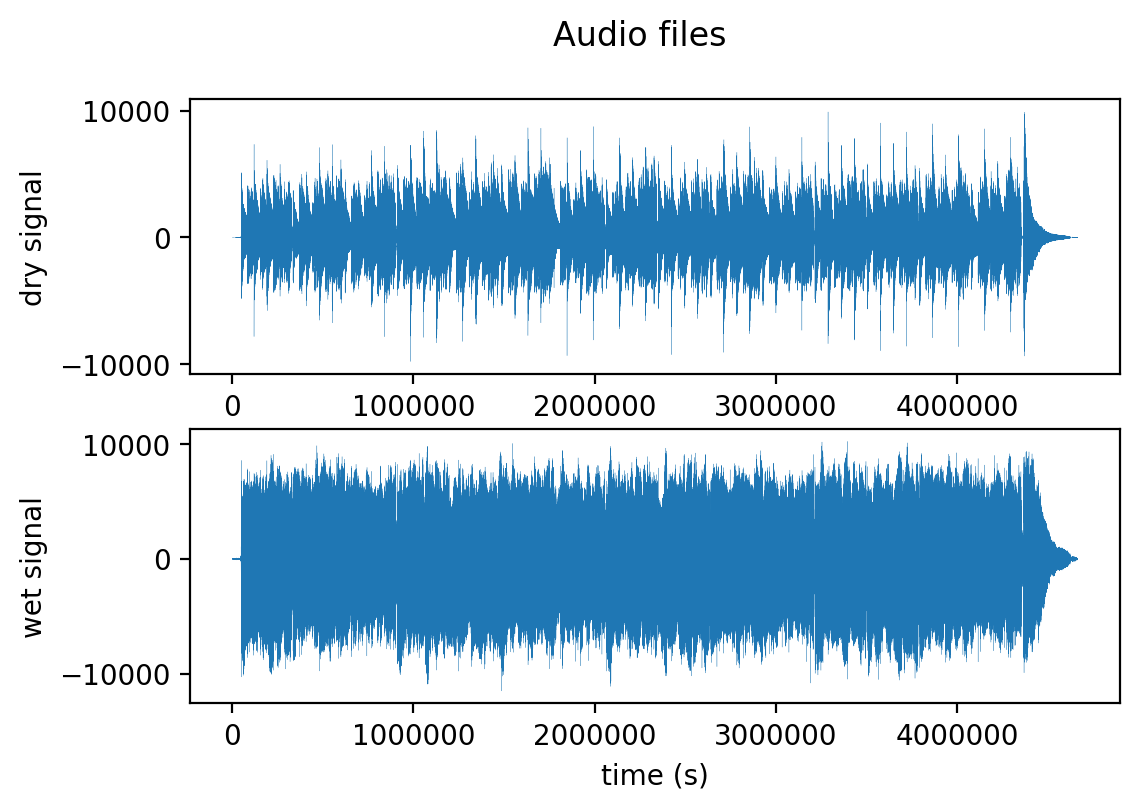

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=200,)
fig.suptitle('Audio files')

ax1.plot(dry_signal,lw=0.1)
ax1.set_ylabel('dry signal')

ax2.plot(wet_signal_mono,lw=0.1)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('wet signal')

In [10]:
buffer = 256

In [11]:
dry_buffer = []
wet_buffer = []

for i0 in range(0,len(dry_signal)//buffer):
    
    shift = i0 * buffer
    
    dry_buffer.append(dry_signal[0 + shift : buffer + shift])
    wet_buffer.append(wet_signal_mono[0 + shift : buffer + shift])
    
dry_buffer = np.array(dry_buffer)
wet_buffer = np.array(wet_buffer)

total_buffer = np.append(dry_buffer,wet_buffer,axis=1)

# Model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import pandas as pd

In [13]:
class My_amp(nn.Module):
    def __init__(self, in_features=256, h1=4096, h2=4096, out_features=256):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [14]:
model = My_amp()

# Train/test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(dry_buffer, wet_buffer, test_size=0.33, random_state=42)

In [16]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# Model training

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(X_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%10 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  1  loss: 3254.73095703
epoch: 11  loss: 1694.13378906
epoch: 21  loss: 1499.26013184
epoch: 31  loss: 1396.63439941
epoch: 41  loss: 1319.48925781
epoch: 51  loss: 1256.78820801
epoch: 61  loss: 1276.15185547
epoch: 71  loss: 1194.56652832
epoch: 81  loss: 1157.81188965
epoch: 91  loss: 1121.35839844
epoch: 101  loss: 1081.08776855
epoch: 111  loss: 1056.79882812
epoch: 121  loss: 1075.50268555
epoch: 131  loss: 1032.65844727
epoch: 141  loss: 1029.36291504
epoch: 151  loss: 1004.75891113
epoch: 161  loss: 976.92193604
epoch: 171  loss: 967.54229736
epoch: 181  loss: 917.63177490
epoch: 191  loss: 1009.41638184
epoch: 201  loss: 934.23181152
epoch: 211  loss: 907.45153809
epoch: 221  loss: 941.51940918
epoch: 231  loss: 858.35388184
epoch: 241  loss: 887.86462402
epoch: 251  loss: 861.30163574
epoch: 261  loss: 890.32733154
epoch: 271  loss: 821.81243896
epoch: 281  loss: 807.25927734
epoch: 291  loss: 798.15167236


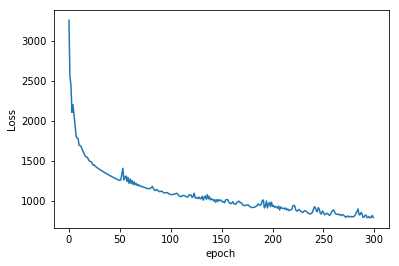

In [19]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

In [25]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model.forward(X_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'{loss:.8f}')

1163.85449219


In [26]:
torch.save(model.state_dict(), 'my_amp_sim.pt')

In [35]:
dry_in = torch.FloatTensor(dry_buffer)
wet_out = torch.FloatTensor(wet_buffer)

with torch.no_grad():
    y_val = model.forward(dry_in)
    loss = torch.sqrt(criterion(y_val, wet_out))
    
print(f'{loss:.8f}')

934.33905029


In [36]:
y_val = np.array(y_val)

In [37]:
out = y_val.flatten()

In [38]:
len(out)

4665088

In [39]:
wavfile.write('test2.wav',48000,out)